In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import pdb

In [ ]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.image_names[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


# Transformations
class SegmentationTransform:
    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

        # To tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask


# U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.down1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bridge = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_block2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_block1 = conv_block(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        b = self.bridge(self.pool2(d2))
        u2 = self.up_block2(torch.cat([self.up2(b), d2], dim=1))
        u1 = self.up_block1(torch.cat([self.up1(u2), d1], dim=1))
        return torch.sigmoid(self.out(u1))


# Trainer
class UNetTrainer:
    def __init__(self, model, train_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.device = device
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=1e-4)

    def train(self, num_epochs=10):
        self.model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for images, masks in self.train_loader:
                images, masks = images.to(self.device), masks.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                print(f"See")

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(self.train_loader):.4f}")

class Evaluator:
    def __init__(self, model, dataloader, device):
        self.model = model.to(device)
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        self.model.eval()
        dice_scores = []
        accuracies = []

        with torch.no_grad():
            for images, masks in self.dataloader:
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)
                preds = (outputs > 0.5).float()

                dice = self.dice_score(preds, masks)
                acc = (preds == masks).float().mean().item()

                dice_scores.append(dice)
                accuracies.append(acc)

        avg_dice = sum(dice_scores) / len(dice_scores)
        avg_acc = sum(accuracies) / len(accuracies)
        print(f"Validation Accuracy: {avg_acc:.4f}, Dice Score: {avg_dice:.4f}")

    @staticmethod
    def dice_score(pred, target, epsilon=1e-6):
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        return (2. * intersection + epsilon) / (union + epsilon)

def predict_single_image(model, image_path, transform, device):
    model.eval()

    # Load original image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # (width, height)

    # Apply transform (resize to 256x256 and tensor conversion)
    dummy_mask = Image.new("L", image.size)
    image_tensor, _ = transform(image, dummy_mask)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = (output > 0.5).float().squeeze().cpu()  # shape: [H, W]
        pdb.set_trace()


    # Convert predicted mask tensor to PIL Image and resize back
    pred_mask_img = TF.to_pil_image(pred_mask)  # from tensor [0,1] → PIL grayscale
    pred_mask_img = pred_mask_img.resize(original_size, resample=Image.NEAREST)

    # Plot side-by-side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_img, cmap="gray")
    plt.title("Predicted Mask (Resized)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Optional: save prediction
    # pred_mask_img.save("prediction.png")


In [19]:

project_folder = "/home/chetan/Desktop/Acads/CS231n/Project/Video-Segmentation-for-Autonomous-Manipulation/"
image_dir = os.path.join(project_folder,"Data/Demo1/raw_images")
mask_dir = os.path.join(project_folder, "Data/Demo1/binary_masks")

assert os.path.exists(image_dir)
assert os.path.exists(mask_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = SegmentationTransform()
dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

model = UNet()
trainer = UNetTrainer(model, dataloader, device)
# trainer.train(num_epochs=1)



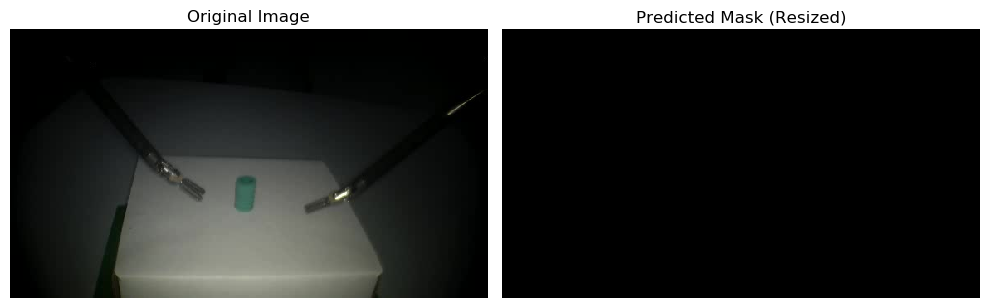

In [22]:
sample_image_name = "00000.jpg"
sample_image_path = os.path.join(image_dir, sample_image_name) 
predict_single_image(model, sample_image_path, transform, device)

## Changing the names and type from jpg to png

In [6]:
from PIL import Image
import os

raw_images_dir = "/Users/chetan/Desktop/Spring 2025/CS231n/Project/Video-Segmentation-for-Autonomous-Manipulation/Data/Three Handed Task/binary_masks"

for fname in os.listdir(raw_images_dir):
    if fname.lower().endswith('.png'):
        png_path = os.path.join(raw_images_dir, fname)
        jpg_name = os.path.splitext(fname)[0] + ".jpg"
        jpg_path = os.path.join(raw_images_dir, jpg_name)
        with Image.open(png_path) as im:
            rgb_im = im.convert('RGB')
            rgb_im.save(jpg_path, quality=95)
        # Optionally, remove the original PNG
        # os.remove(png_path)
        print(f"Converted {fname} -> {jpg_name}")

Converted 0298.png -> 0298.jpg
Converted 0267.png -> 0267.jpg
Converted 0501.png -> 0501.jpg
Converted 0515.png -> 0515.jpg
Converted 0273.png -> 0273.jpg
Converted 0529.png -> 0529.jpg
Converted 0065.png -> 0065.jpg
Converted 0071.png -> 0071.jpg
Converted 0059.png -> 0059.jpg
Converted 0111.png -> 0111.jpg
Converted 0105.png -> 0105.jpg
Converted 0139.png -> 0139.jpg
Converted 0313.png -> 0313.jpg
Converted 0475.png -> 0475.jpg
Converted 0461.png -> 0461.jpg
Converted 0307.png -> 0307.jpg
Converted 0449.png -> 0449.jpg
Converted 0448.png -> 0448.jpg
Converted 0460.png -> 0460.jpg
Converted 0306.png -> 0306.jpg
Converted 0312.png -> 0312.jpg
Converted 0474.png -> 0474.jpg
Converted 0138.png -> 0138.jpg
Converted 0104.png -> 0104.jpg
Converted 0110.png -> 0110.jpg
Converted 0058.png -> 0058.jpg
Converted 0070.png -> 0070.jpg
Converted 0064.png -> 0064.jpg
Converted 0528.png -> 0528.jpg
Converted 0514.png -> 0514.jpg
Converted 0272.png -> 0272.jpg
Converted 0266.png -> 0266.jpg
Converte